# DTOcean Wave Hydrodynamics Test

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, HTML

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14.0, 8.0)

In [4]:
import numpy as np

In [5]:
from dtocean_core import start_logging
from dtocean_core.core import Core
from dtocean_core.menu import ModuleMenu, ProjectMenu
from dtocean_core.pipeline import Tree

In [6]:
def html_list(x):
    message = "<ul>"
    for name in x:
        message += "<li>{}</li>".format(name)
    message += "</ul>"
    return message
def html_dict(x):
    message = "<ul>"
    for name, status in x.iteritems():
        message += "<li>{}: <b>{}</b></li>".format(name, status)
    message += "</ul>"
    return message

In [7]:
# Bring up the logger
start_logging()

## Create the core, menus and pipeline tree

The core object carrys all the system information and is operated on by the other classes

In [8]:
new_core = Core()
project_menu = ProjectMenu()
module_menu = ModuleMenu()
pipe_tree = Tree()

## Create a new project

In [9]:
project_title = "DTOcean"  
new_project = project_menu.new_project(new_core, project_title)

## Set the device type

In [10]:
options_branch = pipe_tree.get_branch(new_core, new_project, "System Type Selection")
variable_id = "device.system_type"
my_var = options_branch.get_input_variable(new_core, new_project, variable_id)
my_var.set_raw_interface(new_core, "Wave Floating")
my_var.read(new_core, new_project)

## Initiate the pipeline
This step will be important when the database is incorporated into the system as it will effect the operation of the pipeline.

In [11]:
project_menu.initiate_pipeline(new_core, new_project)

## Discover available modules

In [12]:
names = module_menu.get_available(new_core, new_project)
message = html_list(names)
HTML(message)

## Activate a module

Note that the order of activation is important and that we can't deactivate yet!

In [13]:
module_name = 'Hydrodynamics'
module_menu.activate(new_core, new_project, module_name)

## Check the status of the module inputs

In [14]:
hydro_branch = pipe_tree.get_branch(new_core, new_project, 'Hydrodynamics')
input_status = hydro_branch.get_input_status(new_core, new_project)
message = html_dict(input_status)
HTML(message)

## Initiate the dataflow
This indicates that the filtering and module / theme selections are complete

In [15]:
project_menu.initiate_dataflow(new_core, new_project)

## Load test data

Prepare the test data for loading. The files required can be found in the test_data directory of the source code and should be copied to the directory that the notebook is running. When the python file is run a pickle file is generated containing a dictionary of inputs.

In [16]:
%run inputs_wp2_wave.py

generate test data: D:\Usuarios\108630\Programming\Python\notebooks\inputs_wp2_wave.pkl


In [17]:
hydro_branch.read_test_data(new_core,
                            new_project,
                            "inputs_wp2_wave.pkl")

## Get a variable from the tree

In [18]:
variable_id = 'farm.rated_power'
my_var = hydro_branch.get_input_variable(new_core, new_project, variable_id)

## Discover which interfaces can be used to enter the variable

Each piece of data must be provided by one or many interfaces, be that raw input or from special file types.

In [19]:
list_raw = my_var.get_raw_interfaces(new_core)
message = html_list(list_raw)
HTML(message)

## Use the interface to enter the variable value

The interface must be "set" (entering the data) and then "connected" (moving the data into the data state)

In [20]:
plant_rated_power = 10.

my_var.set_raw_interface(new_core, plant_rated_power)
my_var.read(new_core, new_project)

## Check that the variable has been entered correctly

In [21]:
device_type = new_core.get_data_value(new_project, variable_id)
display(device_type)

10.0

## Check if the module can be executed

In [22]:
can_execute = module_menu.is_executable(new_core, new_project, module_name)
display(can_execute)

True

In [23]:
input_status = hydro_branch.get_input_status(new_core, new_project)
message = html_dict(input_status)
HTML(message)

## Execute the current module

The "current" module refers to the next module to be executed in the chain (pipeline) of modules. This command will only execute that module and another will be used for executing all of the modules at once.

Note, any data supplied by the module will be automatically copied into the active data state.

In [24]:
module_menu.execute_current(new_core, new_project)

No NOGO areas related to the machine depthinstallation constraints have been found.


## Examine the results

Currently, there is no robustness built into the core, so the assumption is that the module executed successfully. This will have to be improved towards deployment of the final software.

Let's check the number of devices and annual output of the farm, using just information in the data object.

In [25]:
n_devices = new_core.get_data_value(new_project, "farm.number_of_devices")
meta = new_core.get_metadata("farm.number_of_devices")
name = meta.title
message_one = "<p><b>{}:</b> {}</p>".format(name, n_devices)

farm_annual_energy = new_core.get_data_value(new_project, "farm.annual_energy")
meta = new_core.get_metadata("farm.annual_energy")
name = meta.title
value = farm_annual_energy
units = meta.units[0]
message_two = "<p><b>{}:</b> <i>{}</i> ({})</p>".format(name, value, units)

HTML(message_one + message_two)

## Plotting some graphs

By having data objects with set formats it should be possible to create automated plot generation. However, some plots may be too complex and some special cases may need defined.

In [26]:
annual_energy_per_dev_value = new_core.get_data_value(new_project, 
                                                     "farm.annual_energy_per_device")
meta = new_core.get_metadata("farm.annual_energy_per_device")

chart_values = np.array(annual_energy_per_dev_value.values())

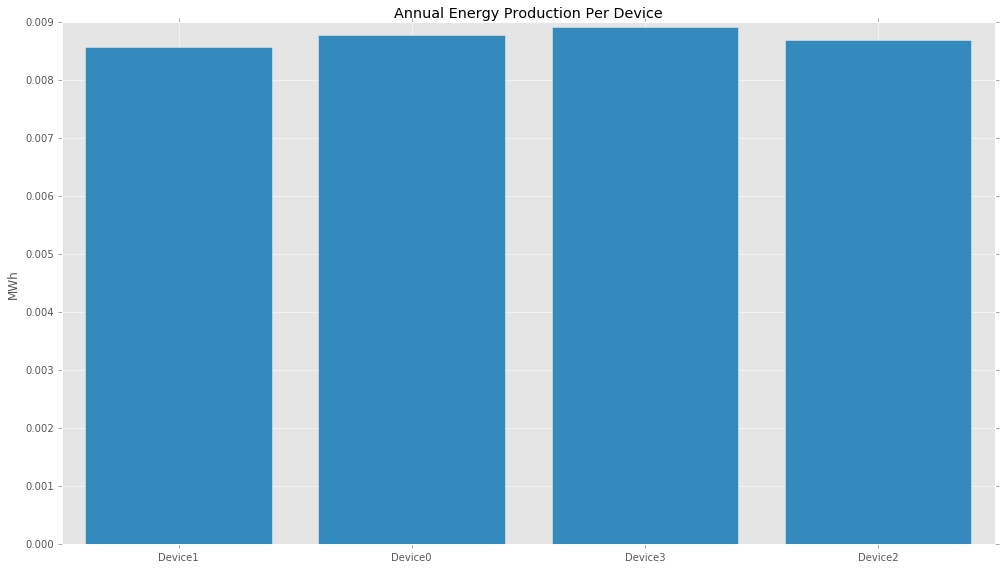

In [27]:
plt.bar(range(len(annual_energy_per_dev_value)),
        chart_values,
        align='center')
            
plt.xticks(range(len(annual_energy_per_dev_value)),
           annual_energy_per_dev_value.keys())
plt.title(meta.title)

plt.ylabel(meta.units[0])

plt.tight_layout()
# plt.savefig('annual_energy_per_device.png')
plt.show()

## Plotting the Layout

This may require such a special case. It is not clear is a new data type is required or just special plots associated to variable IDs.

In [28]:
layout_value = new_core.get_data_value(new_project, "farm.layout")
layout_meta = new_core.get_metadata("farm.layout")

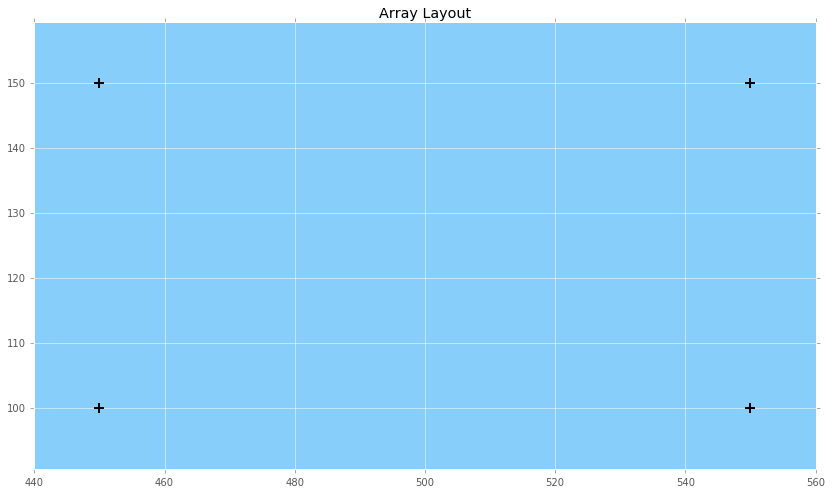

In [29]:
x = []
y = []

for coords in layout_value.itervalues():
    
    x.append(coords.x)
    y.append(coords.y)

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1, axisbg='lightskyblue')
ax1.plot(x,y,'k+', mew=2, markersize=10)
plt.title(layout_meta.title)
plt.axis('equal')
plt.show()